<a href="https://colab.research.google.com/github/sashavlasits/Data-Science/blob/main/Unit4/SMVUnit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "preliz[full,notebook]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.8/515.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.5/519.5 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.1 MB/s eta 0:00:00


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import preliz as pz

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [3]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

In [4]:
cs_data

,ID,aa,theo,exp,cat
0,1BM8,ILE,61.18,58.27,Non-Polar
1,1BM8,TYR,56.95,56.18,Polar
2,1BM8,SER,56.35,56.84,Polar
3,1BM8,ALA,51.96,51.01,Special
4,1BM8,ARG,56.54,54.64,Charged
...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,Charged
1772,1KS9,ARG,58.91,59.02,Charged
1773,1KS9,LYS,59.49,58.92,Charged
1774,1KS9,GLU,59.48,58.36,Charged


In [5]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode

['ILE', 'TYR', 'SER', 'ALA', 'ARG', ..., 'LYS', 'ARG', 'LYS', 'GLU', 'SER']
Length: 1776
Categories (19, object): ['ALA', 'ARG', 'ASN', 'ASP', ..., 'THR', 'TRP', 'TYR', 'VAL']

In [6]:
aa_idx = aa_encode.codes
aa_idx

array([ 8, 17, 14, ..., 10,  5, 14], dtype=int8)

In [7]:
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [8]:
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [ ]:
cs_data

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_modelT:
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu = 1)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu = 1)
    μ_nu = pm.Exponential('μ_nu', lam = .2)

    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  nu = μ_nu,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', sigma = 10, nu = μ_nu,
                      dims = "aa")
    ν = pm.Exponential('ν', lam = .2, dims = 'aa')


    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = ν[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_hT = pm.sample()

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx], #I include the prior in my likelihood
                  sigma = σ[aa_idx], #I include the prior in my likelihood
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

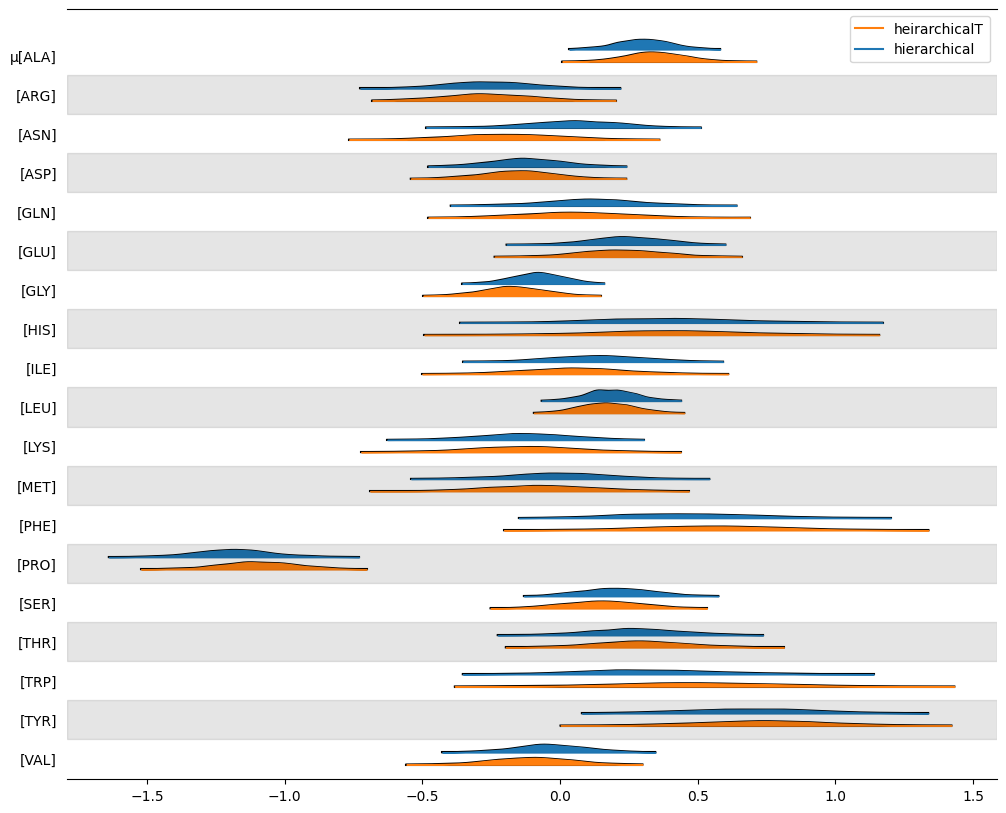

In [ ]:
axes = az.plot_forest([idata_cs_hT, idata_cs_h], kind="ridgeplot",
                      model_names=['hierarchical', 'heirarchicalT'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [ ]:
pm.sample_posterior_predictive(idata_cs_hT, model=cs_h_modelT, extend_inferencedata=True)

<Axes: xlabel='y'>

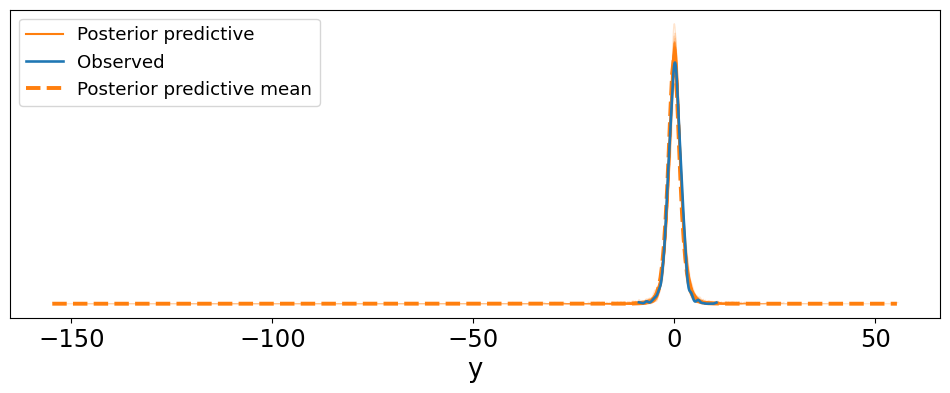

In [ ]:
az.plot_ppc(idata_cs_hT, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

In [ ]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)

<Axes: xlabel='y'>

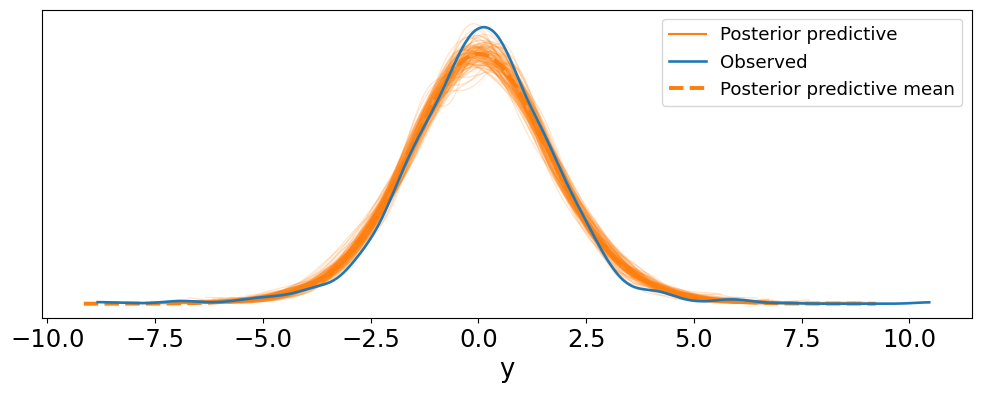

In [ ]:
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

I think that, overall, the normal heriarchical model looks a little bit closer, but they areboth queis good fits for the data.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [10]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [11]:
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [ ]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

<Axes: >

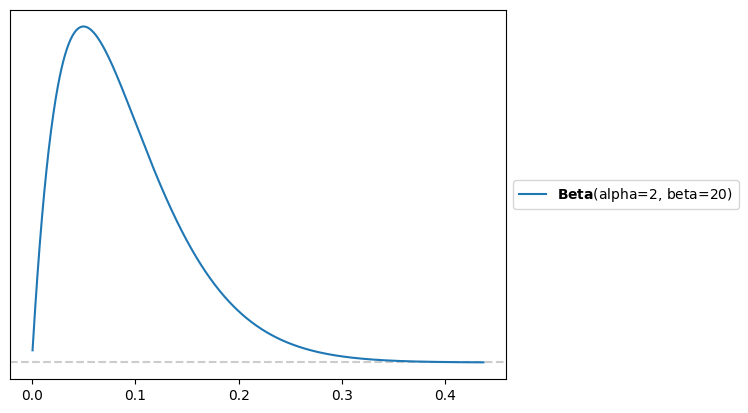

In [ ]:
pz.Beta(alpha = 2, beta = 20).plot_pdf()

In [ ]:
pz.Beta(alpha = 2, beta = 20).moments('mvsk')

[np.float64(0.09090909090909091),
 np.float64(0.0035932446999640674),
 np.float64(1.1374313166077326),
 np.float64(1.623)]

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_modelnh:

    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = .0909, nu = 2 , dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccrnh = pm.sample(target_accept = 0.95)

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

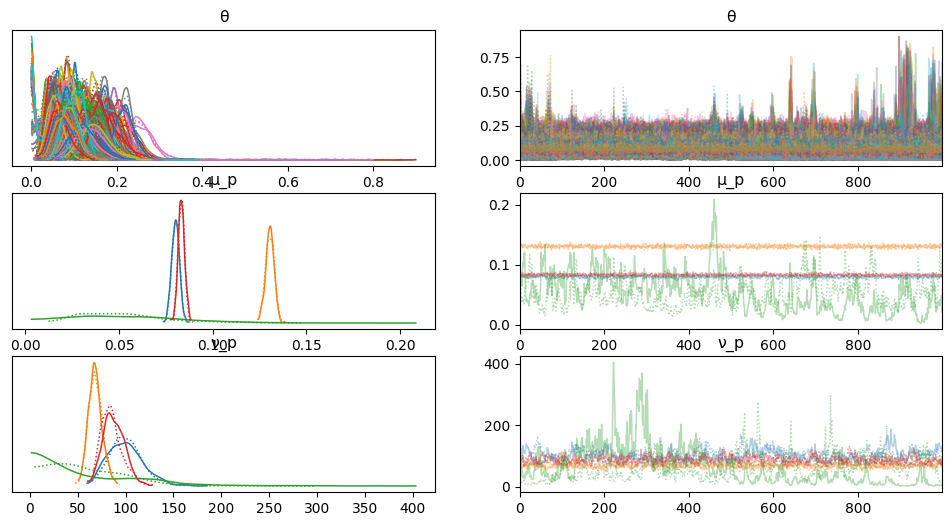

In [ ]:
az.plot_trace(idata_sccrnh)

In [ ]:
az.rhat(idata_sccrnh)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.0 0.9993 0.9998 ... 1.002 1.001 1.001
    μ_p      (pos) float64 32B 1.001 1.002 1.254 1.0
    ν_p      (pos) float64 32B 1.016 0.9997 1.446 1.012

Honestly, these seem to be pretty similar. The goalkeeper data is still quite freaky and the r hat values continue to suggest this. The graphs differ a little bit, but not in any very important way. A slight difference is just to be expected given that we're running a new thing.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Text(0.5, 1.0, 'Midfielder position mean')

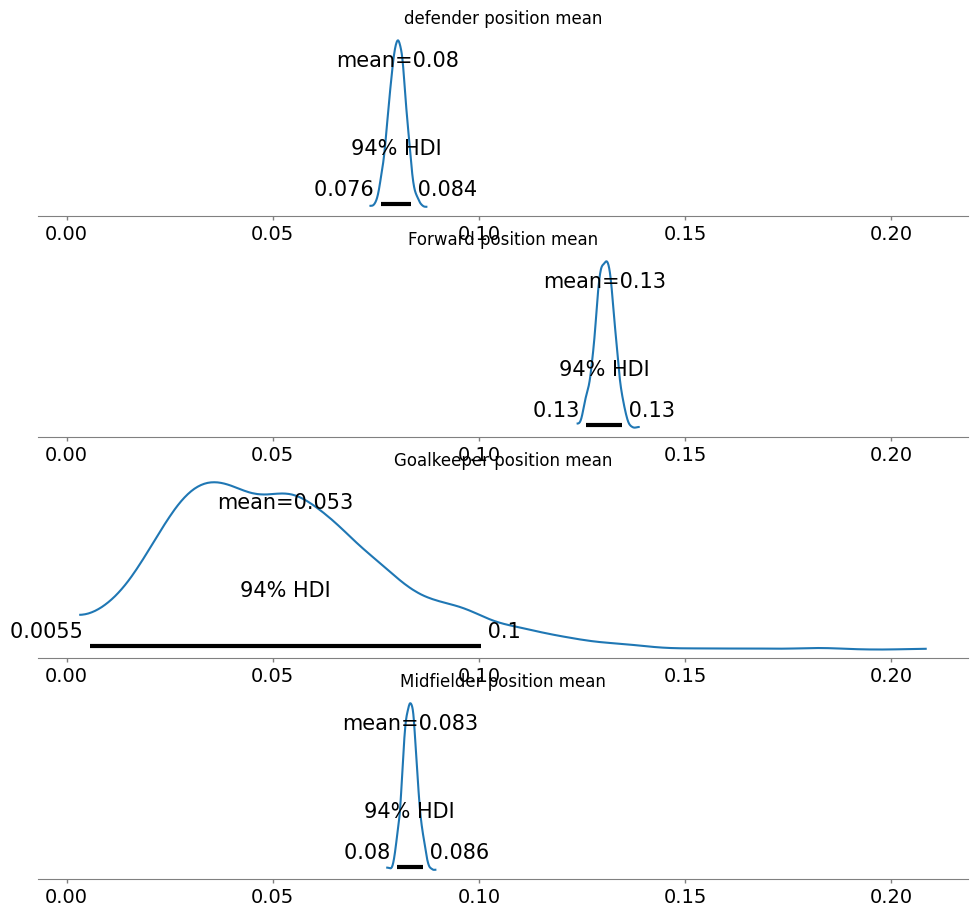

In [ ]:
##non-heirarchical
_, ax = plt.subplots(4, 1, figsize=(12, 11), sharex=True)

az.plot_posterior(idata_sccrnh.posterior.sel(pos="DF"), var_names='μ_p', ax=ax[0])
ax[0].set_title(r"defender position mean")

az.plot_posterior(idata_sccrnh.posterior.sel(pos="FW"), var_names='μ_p', ax=ax[1])
ax[1].set_title(r"Forward position mean")

az.plot_posterior(idata_sccrnh.posterior.sel(pos="GK"), var_names='μ_p', ax=ax[2])
ax[2].set_title(r"Goalkeeper position mean")

az.plot_posterior(idata_sccrnh.posterior.sel(pos="MF"), var_names='μ_p', ax=ax[3])
ax[3].set_title(r"Midfielder position mean")


Text(0.5, 1.0, 'Midfielder position mean')

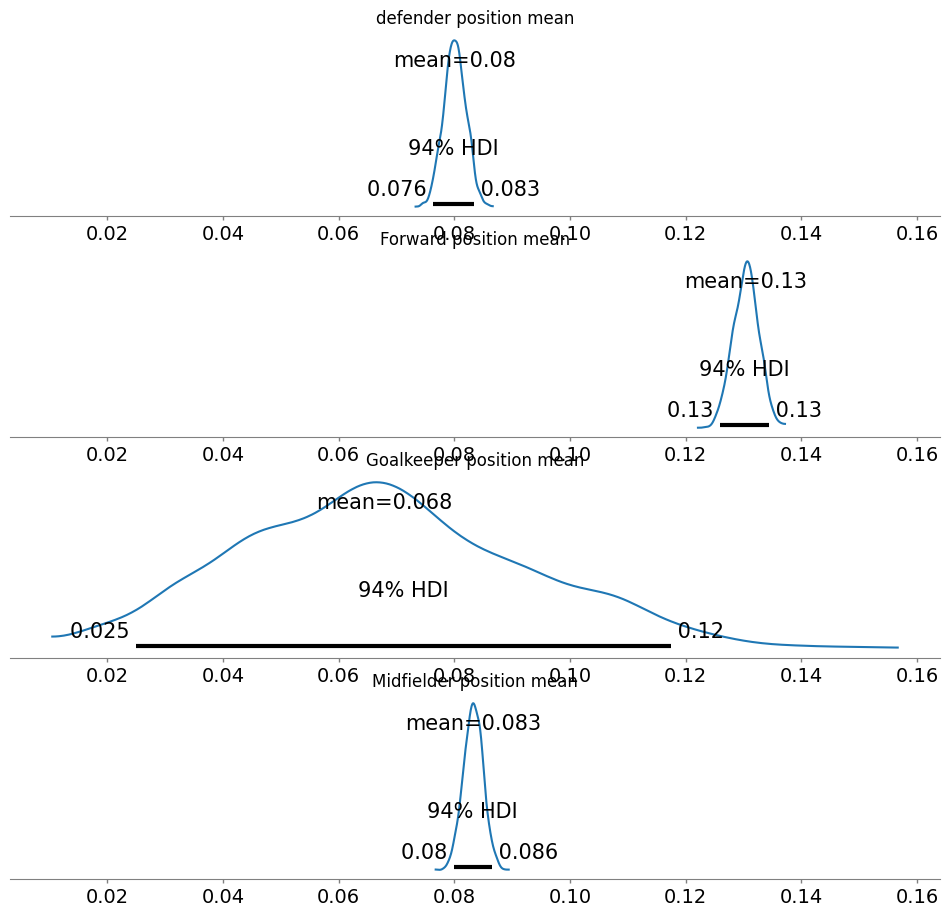

In [ ]:
##heirarchical
_, ax = plt.subplots(4, 1, figsize=(12, 11), sharex=True)

az.plot_posterior(idata_sccr.posterior.sel(pos="DF"), var_names='μ_p', ax=ax[0])
ax[0].set_title(r"defender position mean")

az.plot_posterior(idata_sccr.posterior.sel(pos="FW"), var_names='μ_p', ax=ax[1])
ax[1].set_title(r"Forward position mean")

az.plot_posterior(idata_sccr.posterior.sel(pos="GK"), var_names='μ_p', ax=ax[2])
ax[2].set_title(r"Goalkeeper position mean")

az.plot_posterior(idata_sccr.posterior.sel(pos="MF"), var_names='μ_p', ax=ax[3])
ax[3].set_title(r"Midfielder position mean")

The means of the curves are incredibly similar, as are the general shape of the curves. The only real difference that I can see is between the goalkeeper distributions. The nonheirarchical has a lower mean and less vairance than the heirarchical one. This is prbably just becuase of the fact that the goalkeeper data is generally freaky, not anything to do with the model.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [38]:
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [63]:
sccrNOGK_data=sccr_data.query('position!="GK"')

sccrNOGK_data.position=sccrNOGK_data.position.cat.remove_unused_categories()
sccrNOGK_data.position.cat.categories

/tmp/ipython-input-721280996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sccrNOGK_data.position=sccrNOGK_data.position.cat.remove_unused_categories()


Index(['DF', 'FW', 'MF'], dtype='object')

In [64]:
sccrNOGK_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [68]:
pos_idxNOGK = sccrNOGK_data.position.cat.codes.values

pos_codesNOGK = sccrNOGK_data.position.cat.categories

sccrNOGK_coordsNOGK = {"pos": pos_codesNOGK}

pos_codesNOGK


Index(['DF', 'FW', 'MF'], dtype='object')

In [ ]:
with pm.Model(coords = sccrNOGK_coordsNOGK) as sccrNOGK_model:

    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    θ = pm.Beta('θ', mu = μ_p[pos_idxNOGK], nu = ν_p[pos_idxNOGK])


    _ = pm.Binomial('gs',
                    n = sccrNOGK_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccrNOGK_data.goals.values) #goals per player


    idata_sccrNOGK = pm.sample(target_accept = 0.95)

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

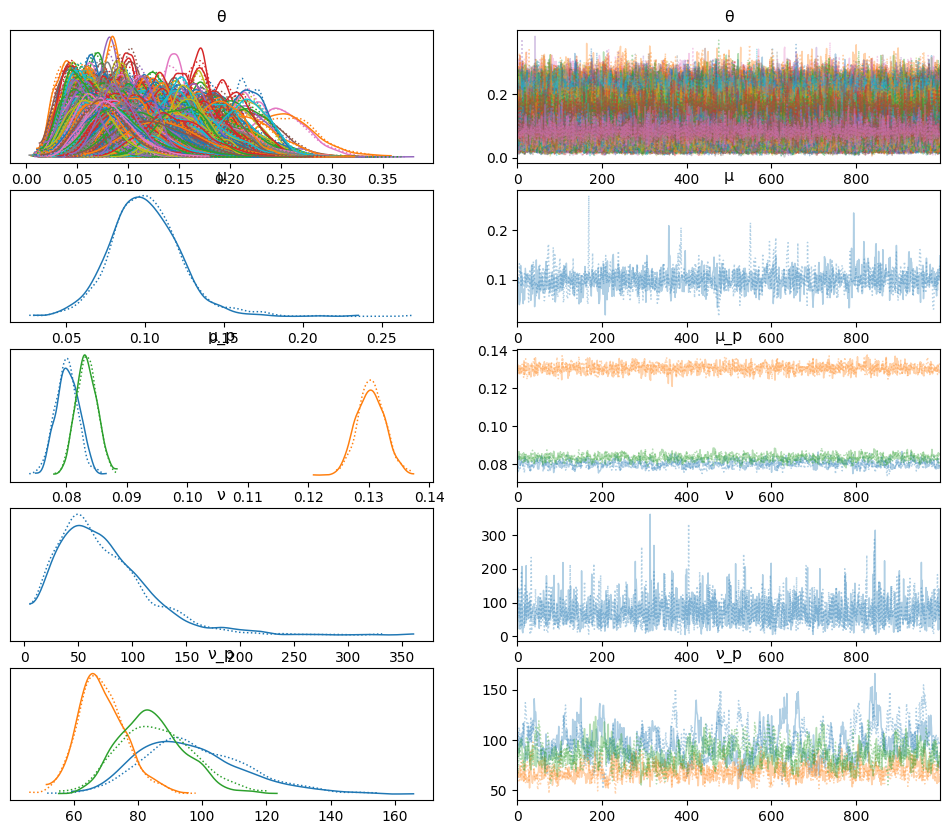

In [70]:
az.plot_trace(idata_sccrNOGK)

In [71]:
az.rhat(idata_sccrNOGK)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.001 0.9999 1.0 1.001 ... 1.001 1.003 1.005
    μ        float64 8B 1.003
    μ_p      (pos) float64 24B 1.014 1.001 1.002
    ν        float64 8B 1.001
    ν_p      (pos) float64 24B 1.015 1.009 1.03

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

The graphs for the run without the goalkeepers seem to overall seeem more normal. This is largely because we don't have the freakiness of the goalkeeper data that made a really weird looking distribution and just overall made things worse. Removing them also made the r hat values more favorable, because it took away the freaky goalkeepers. PYMC seemed to have a slightly easier time on the second model, but the times were overall relatively similar. Both times the run of the model got some errors.

When we remove the goalkeepers, we lose the insights into the skills of goalkeepers at making shots, but that's not that important. More importantly, we remove the effect that the goalkeeper distributions have on the other, more normal graphs for position, making them more acurrate. And that's great!